# <center>Lab Three Association Rule Mining, Clustering, or Collaborative Filtering</center>
<center><font size = "4"> Australian Weather Station Collection Data 2007-2017</font></center>

##### <center>Create by An Nguyen, Andy Ho, Jodi Pafford</center>
<center> April 14, 2019</center>

# Total Points

# Business Understanding
<b>Describe the purpose of the data set you selected (i.e.,why was this data collected in the first place?). How will you measure the effectiveness of a good algorithm? Why does your chosen validation method make sense for this specific dataset and the stakeholders needs?</b>



This project is based off of a rainfal prediction dataset from Australia. The original data file named 'weatherAus.csv' was outputted as 'rainfall.csv' after our pre-processing.  The data set contains daily weather observations from numerous Australian weather stations.  The daily observations are available from http://www.bom.gov.au/climate/data. Copyright Commonwealth of Australia 2010, Bureau of Meteorology.  

The following is the data meaning types for the features used for Lab Two (19 variables by class type):

- Int64: RainToday, RainTomorrow
- Float64: MinTemp, MaxTemp, Rainfall, WindGustDir, WindGustSpeed, WindDir9am, WindDir3pm, WindSpeed9am, WindSpeed3pm, Humidity9am, Humidity3pm, Pressure9am, Pressure3pm, Cloud9am, Cloud3pm, Temp9am, Temp3pm

Codebook in its entirety can be found at https://www.kaggle.com/jsphyg/weather-dataset-rattle-package.

The original data set had 140,787 observations and 24 features.  After pre-processing, dimension reduction occurred leaving the new data set at 101,328 observations and 19 features.  Observations were removed if it contained any NaNs within its features.  The following features were removed:

- Evaporation : Too many NaNs to impute
- Sunshine: Too many NaNs to impute
- Date: Feature not required for classification and/or prediction
- Location: Feature not required since we're predicting rain or not for Australia and not by cities
- RISK_MM: Feature not required since it measures the amount of rain.  Would impact modeling results.

We also decided for classification/regression purposes, to convert the "Cardinal Directions" to degrees.  For example, N':0, 'NNE':22.5, 'NE':45, 'NE':45, and so on. 

The reduction of features will help make our proposed model simpler and mitigate the probabiilty of overfitting.  Since the data set has over a hundred thousand observations, we had sufficient number of observations that removing the observations with NaNs would not interfere with our training and test set results (i.e. accuracy).

Further modeling and various evaluations will be required to better understand which measure are most appropriate for analyzing the results of our modeling.  

This algorithm will be measured for effectiveness using a clustering algorithm in classifying rainfall throughtout Asutralia.

We will be using  The Adjsuted Rand Score (ARS) and Calinski_Harabaz for validation.  

The Rand score (RS) is measure of similarity between the predicted and true clustering.  ARS is the RS "adjusted for chance"  using this equation:

ARS = (RS - Expected_RS) / (max(RS) - Expected_RS)
    
An ARS of 0.0 indicates a random labeling of each points and a 1.0 score indicate a perfect labeling.

 Calinski-Harabaz score or the Variance Ratio Criterion.  The Calinski-Harabaz score is used when the true labels are not known.  This score is a ratio between the within-cluster dispersion and the between-cluster dispersion.  The higher the score the better.

# Data Understanding 1
<b>Visualize the any important attributes appropriately. Important: Provide an interpretation for any charts or graphs.</b>

In [1]:
import seaborn
import pandas

#Assign values to response variable, y, and explanatory variables, x.
rainfall = pandas.read_csv('rainfall.csv', index_col=0) 
temp_rainfall = rainfall.copy()

# Visualising missing data:
seaborn.heatmap(temp_rainfall.isnull(),yticklabels=False,cbar=False,cmap='Reds_r')

#Variables 'Evaporation' and 'Sunshine' contained many missing values, too many to be imputed.
temp_rainfall = temp_rainfall.drop(['Evaporation', 'Sunshine'], axis = 1)

#Get name of all cities in the data frame.
l = list(temp_rainfall.Location.unique())

#Drop all observations with NaN's.  These are values that could not be imputed using the above code.
temp_rainfall.dropna(subset = list(temp_rainfall), inplace = True)

#List all cities that were dropped
for i in l:
    if i not in temp_rainfall.Location.unique():
        print(i)
        
#'Date' and 'Location' variables not needed for prediction. 
temp_rainfall = temp_rainfall.drop(['Date', 'Location'], axis = 1)

BadgerysCreek
Newcastle
NorahHead
Penrith
Tuggeranong
MountGinini
Nhil
Dartmoor
GoldCoast
Adelaide
Albany
Witchcliffe
SalmonGums
Walpole


In [40]:
temp_rainfall.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101328 entries, 0 to 140786
Data columns (total 19 columns):
MinTemp          101328 non-null float64
MaxTemp          101328 non-null float64
Rainfall         101328 non-null float64
WindGustDir      101328 non-null float64
WindGustSpeed    101328 non-null float64
WindDir9am       101328 non-null float64
WindDir3pm       101328 non-null float64
WindSpeed9am     101328 non-null float64
WindSpeed3pm     101328 non-null float64
Humidity9am      101328 non-null float64
Humidity3pm      101328 non-null float64
Pressure9am      101328 non-null float64
Pressure3pm      101328 non-null float64
Cloud9am         101328 non-null float64
Cloud3pm         101328 non-null float64
Temp9am          101328 non-null float64
Temp3pm          101328 non-null float64
RainToday        101328 non-null int64
RainTomorrow     101328 non-null int64
dtypes: float64(17), int64(2)
memory usage: 15.5 MB


0    109586
1     31201
Name: RainTomorrow, dtype: int64


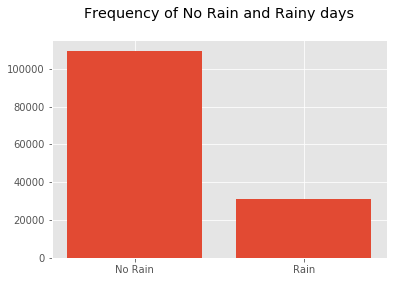

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot')
plt.figure(figsize=(6,4))
plt.hist(rainfall['RainTomorrow'],bins=2,rwidth=0.8)
plt.xticks([0.25,0.75],['No Rain','Rain'])
plt.title('Frequency of No Rain and Rainy days\n')
print(rainfall['RainTomorrow'].value_counts())

As you can see from the image above, the data is skewed in the number days that it actually rained and the days it did not rain.  There were over 3 times as many days that didn't rain as days that did. This is important to note because it changes the way that we evaluate our data when looking for key variables to use for the clustering.

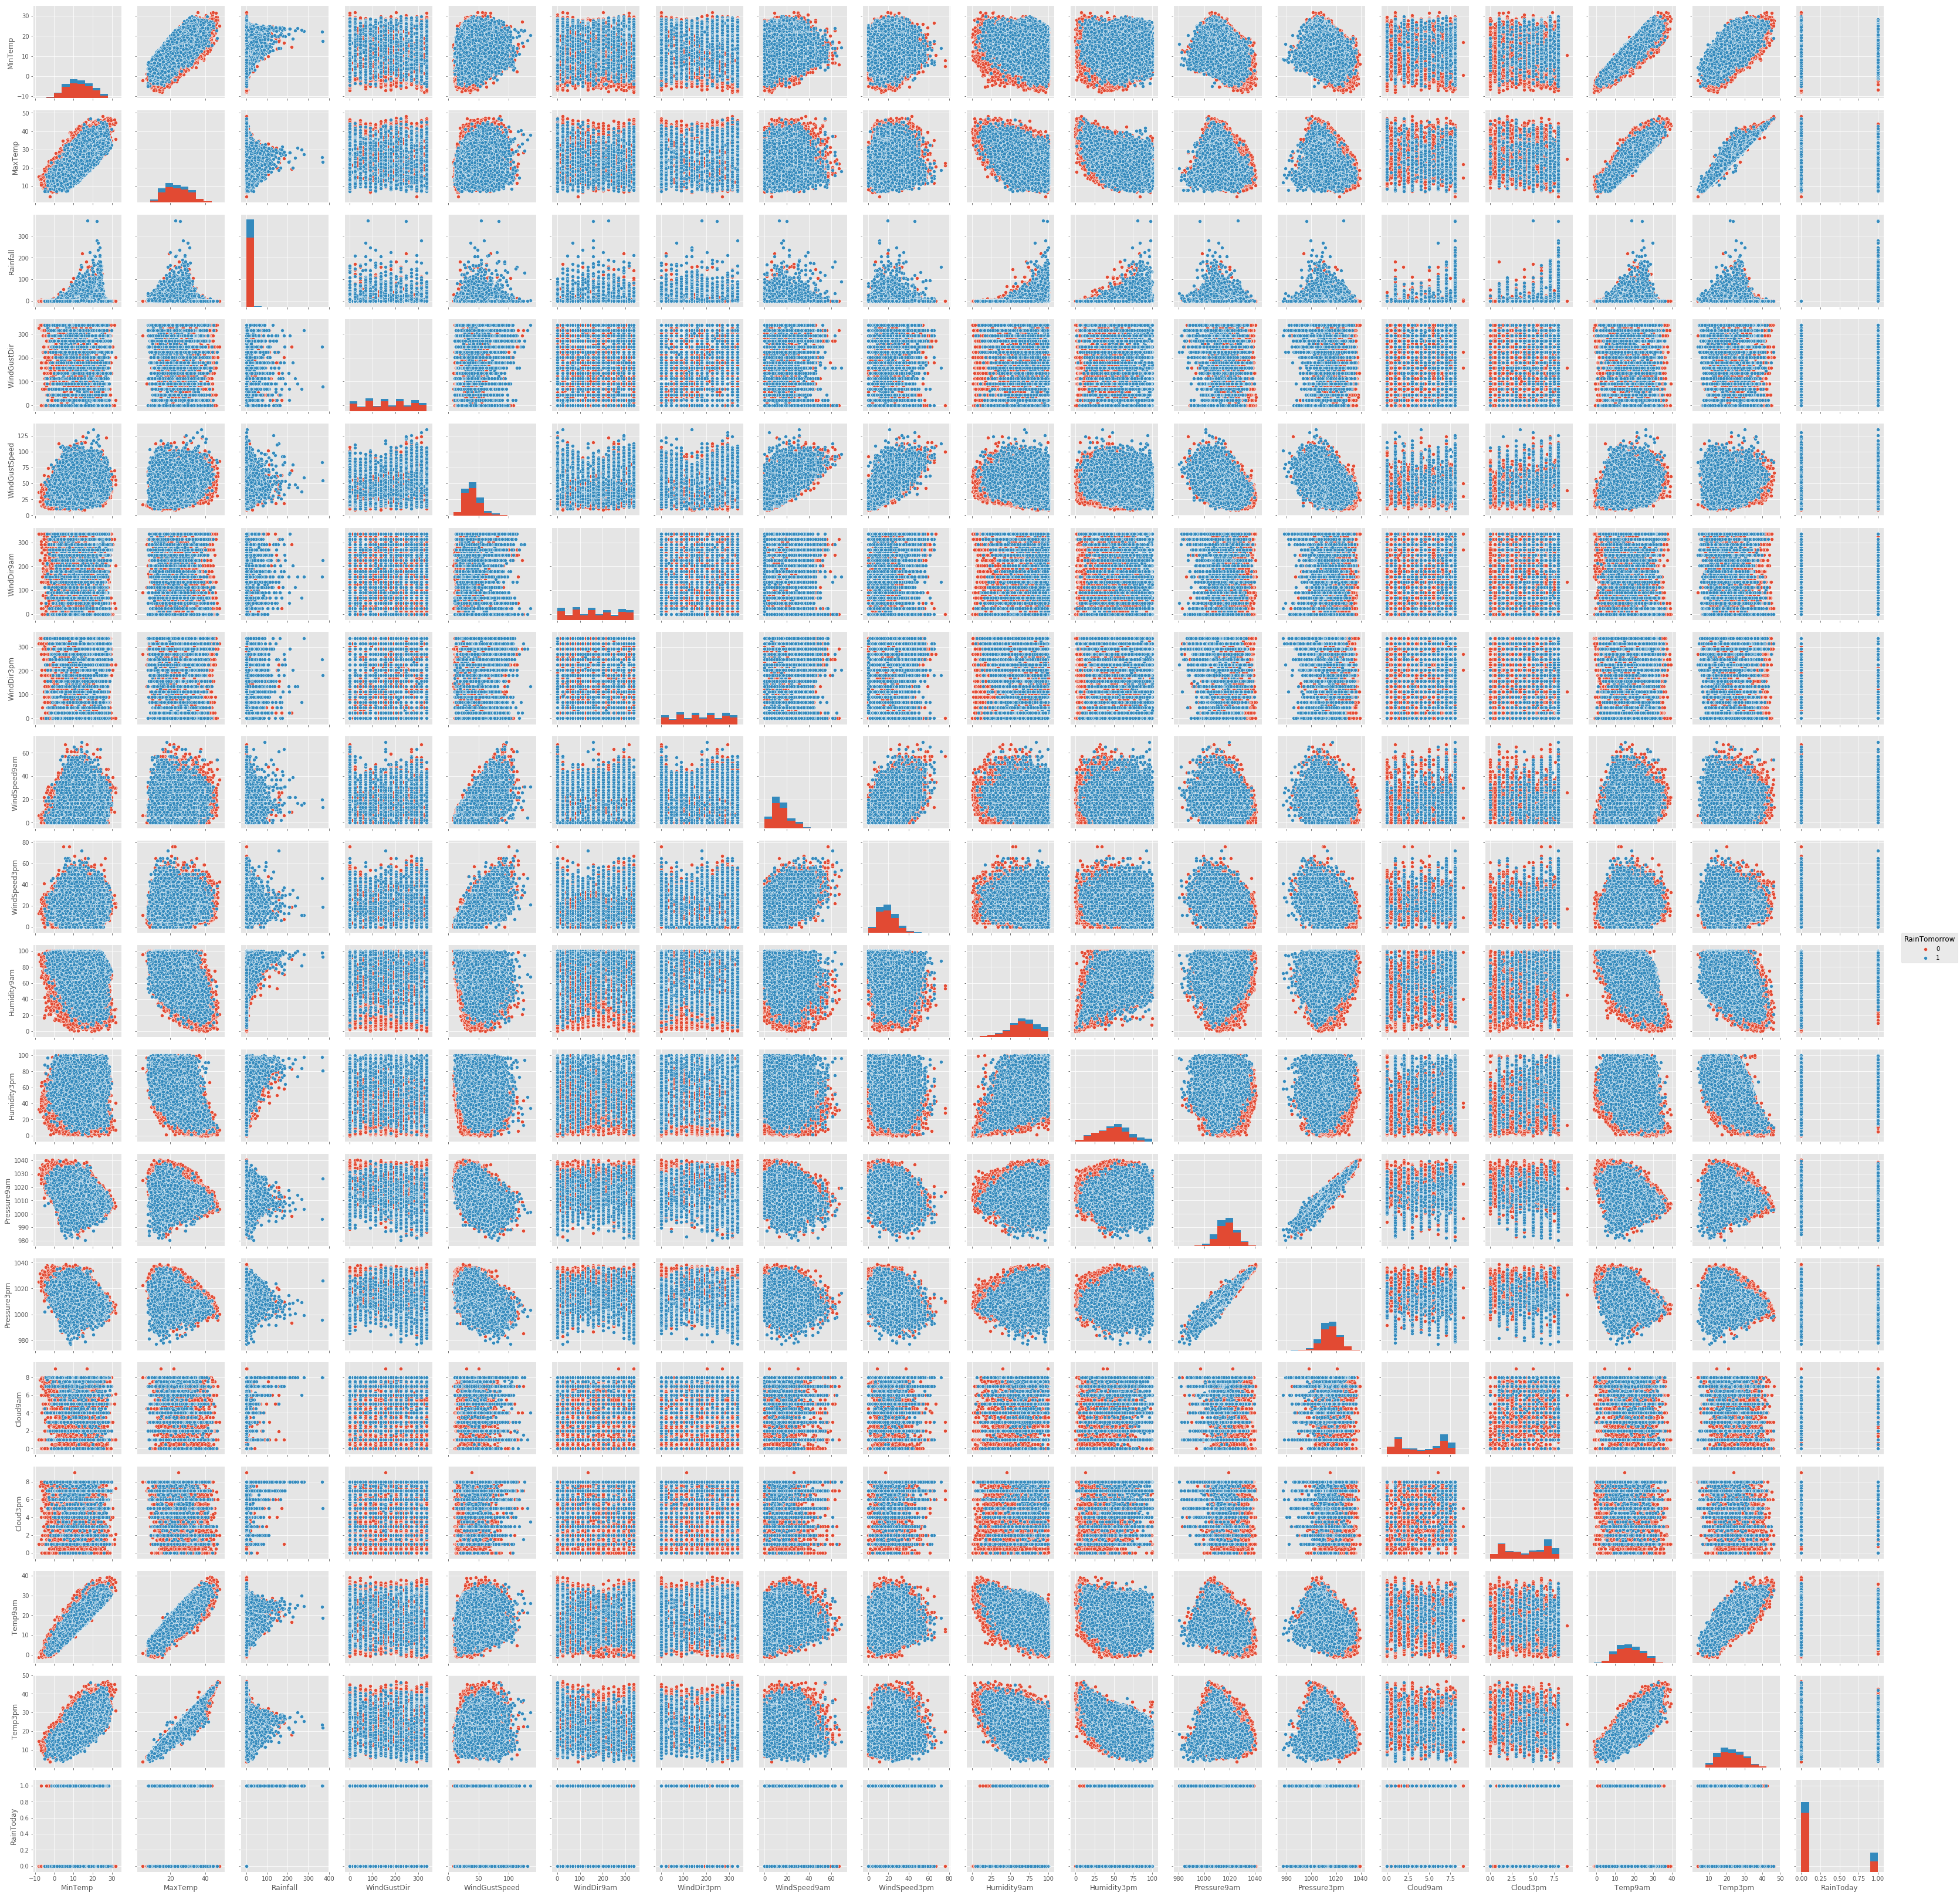

In [50]:
import seaborn as sns

sns.pairplot(rainfall.dropna()
             , vars=['MinTemp','MaxTemp', 'Rainfall' ,'WindGustDir','WindGustSpeed','WindDir9am','WindDir3pm','WindSpeed9am','WindSpeed3pm'
                     ,'Humidity9am','Humidity3pm','Pressure9am','Pressure3pm','Cloud9am','Cloud3pm','Temp9am','Temp3pm'           ,'RainToday']
             , hue='RainTomorrow')

Additionally, looking at this matrix allowed us to see how many variables are similar to one another in relation.  Based on this and lab 2, we were able to create a dataset with using RainToday, MinTemp, Humidity9am, and RainTomorrow.

In [3]:
#From lab 2 we were able to determine the three top features that contributed the most to rainfall prediction.  We will use
#these three features to cluster the rain vs no rain.

selected_features = ['RainToday', 'MinTemp', 'Humidity9am', 'RainTomorrow']

feature_select=temp_rainfall[selected_features].copy()
feature_select.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101328 entries, 0 to 140786
Data columns (total 4 columns):
RainToday       101328 non-null int64
MinTemp         101328 non-null float64
Humidity9am     101328 non-null float64
RainTomorrow    101328 non-null int64
dtypes: float64(2), int64(2)
memory usage: 3.9 MB


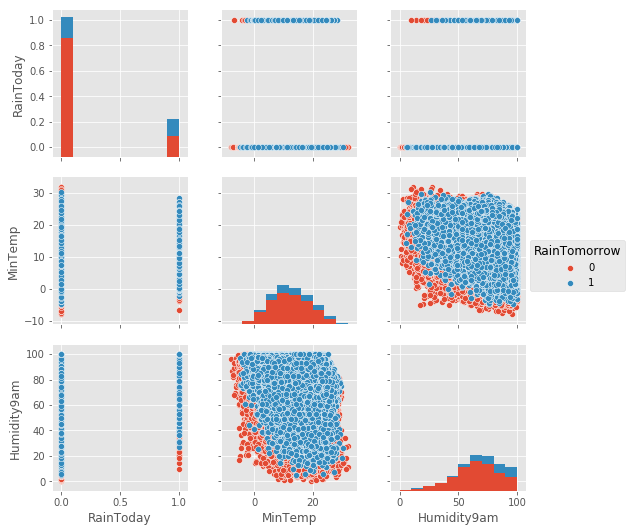

In [5]:
import seaborn as sns

sns.pairplot(feature_select.dropna()
             , vars=['RainToday', 'MinTemp', 'Humidity9am']
             , hue='RainTomorrow')

# Data Understanding 2
<b>Choose and explain your evaluation metrics that you will use (i.e., accuracy, precision, recall, F-measure, or any metric we have discussed). Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertations.</b>

For the clustering task, we chose to use the F1 calculation as our evaluation metrics. The F1 measure is the weighted average of Precision and Recall. The dataset we are using is not senstive to False Positive like that of a medical study and therefore it is not as important to use Precision and Recall alone. Accuracy is not the best choice when the classes are not close to equal in sizes and therefore not a good fit for this dataset. Class size is demonstrated below. F1 Calculation, 2(Recall  Precision)/(Recall + Precision), will be used as our evaluation metric of choice.

This doesn't quite fit with Lab 3, but since we used information and data from lab 2 to help us in lab 3, we have included that information here.

# Modeling and Evaluation 1
<b>Train and adjust parameters.</b>

In [6]:
#Response variable is 'RainTomorrow'
y = temp_rainfall['RainTomorrow'].values
y_fs = feature_select['RainTomorrow'].values

#Remove response variable from dataframe
del temp_rainfall['RainTomorrow']
del feature_select['RainTomorrow']

#Everything else is the explanatory variables used in prediction.
x = temp_rainfall.values
x_fs = feature_select.values   


In [9]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import sklearn.metrics
import time

def bench_k_means(estimator, name, data):
    t0 = time.time()
    y_hat=estimator.fit_predict(data)
    print(name)
    print("Adjusted Rand Score (-1 to 1): %f" %(sklearn.metrics.adjusted_rand_score(y, y_hat)))
    print("Calinski-Harabaz Score (higher scores relates to better defined clusters): %f"
          %(sklearn.metrics.calinski_harabaz_score(X=data, labels=y_hat)))
    return y_hat
    
scl_obj = StandardScaler()
scl_obj.fit(x)
x_scaled = scl_obj.transform(x)
scl_obj.fit(x_fs)
x_fs_scaled = scl_obj.transform(x_fs)
    
bench_k_means(KMeans(init='random', n_clusters=2), name="random", data=x)
bench_k_means(KMeans(init='k-means++', n_clusters=2), name="k-means++", data=x)
bench_k_means(KMeans(init='random', n_clusters=2), name="random, scaled", data=x_scaled)
bench_k_means(KMeans(init='k-means++', n_clusters=2), name="k-means++, scaled", data=x_scaled)
bench_k_means(KMeans(init='random', n_clusters=2), name="random, featured selected", data=x_fs)
bench_k_means(KMeans(init='k-means++', n_clusters=2), name="k-means++, featured selected", data=x_fs)
bench_k_means(KMeans(init='random', n_clusters=2), name="random, featured selected, scaled", data=x_fs_scaled)
bench_k_means(KMeans(init='k-means++', n_clusters=2), name="k-means++, featured selected, scaled", data=x_fs_scaled)


random
Adjusted Rand Score (-1 to 1): 0.001697
Calinski-Harabaz Score (higher scores relates to better defined clusters): 64454.289860
k-means++
Adjusted Rand Score (-1 to 1): 0.001687
Calinski-Harabaz Score (higher scores relates to better defined clusters): 64454.293215
random, scaled
Adjusted Rand Score (-1 to 1): -0.000692
Calinski-Harabaz Score (higher scores relates to better defined clusters): 23179.842637
k-means++, scaled
Adjusted Rand Score (-1 to 1): -0.000902
Calinski-Harabaz Score (higher scores relates to better defined clusters): 23179.877230
random, featured selected
Adjusted Rand Score (-1 to 1): 0.004680
Calinski-Harabaz Score (higher scores relates to better defined clusters): 140168.638083
k-means++, featured selected
Adjusted Rand Score (-1 to 1): 0.004894
Calinski-Harabaz Score (higher scores relates to better defined clusters): 140167.184840
random, featured selected, scaled
Adjusted Rand Score (-1 to 1): 0.202504
Calinski-Harabaz Score (higher scores relates to 

array([0, 0, 0, ..., 0, 0, 0])

- Unscaled data of the dataset with feature selected resulted in a better Adjusted Rand Score and Calinski-Harabaz Score, will use this dataset to test if DBSCAN will provide a better model.


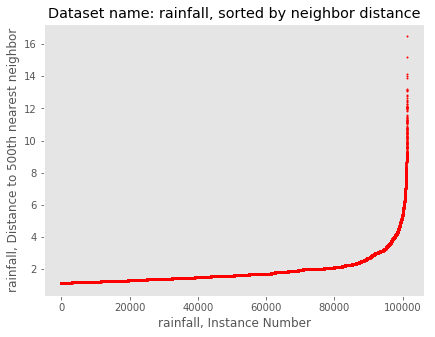

In [7]:
from sklearn.neighbors import kneighbors_graph
import matplotlib.pyplot as plt
import numpy

n=500 #x=1, 10, 50, 100, 500
X2_knn_graph = kneighbors_graph(x_fs, n, mode='distance') # calculate distance to x nearest neighbors

N2 = X2_knn_graph.shape[0]
X2_4nn_distances = numpy.zeros((N2,1))
for i in range(N2):
    X2_4nn_distances[i] = X2_knn_graph[i,:].max()

X2_4nn_distances = numpy.sort(X2_4nn_distances, axis=0)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(range(N2), X2_4nn_distances, 'r.', markersize=2) #plot the data
plt.title('Dataset name: rainfall, sorted by neighbor distance')
plt.xlabel('rainfall, Instance Number')
plt.ylabel('rainfall, Distance to {0}th nearest neighbor'.format(n))
plt.grid()

Based on the plot above, we choose the epsilon value of 5. Based on that we will run DBSCAN again.

In [17]:
from sklearn.cluster import DBSCAN

labels=bench_k_means(DBSCAN(eps=3.5, min_samples=500), name="DBSCAN", data=x_fs)

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels))
    
print('Estimated number of clusters: %d' % n_clusters_)

DBSCAN
Adjusted Rand Score (-1 to 1): -0.020644
Calinski-Harabaz Score (higher scores relates to better defined clusters): 12524.657326
Estimated number of clusters: 2


# Modeling and Evaluation 2
<b>Evaluate and Compare</b>

- Scaling the observations to their means resulted in less accuracy and cluster formations, Adjusted Rand score in the negative and Calinski-Harabaz score is 17820.4 to the 49773.9 of the un-scaled dataset.
- Using a random initilization or an initialization where the centroids' distances are maximized did not seem to have much of an effect on accuracy or cluster formation.
- DBSCAN resulted in a much lower Calinski-Harabaz score, 38.1, then KMeans, 49773.0.  Indicating that DBSCAN had less defined clusters.  
- DBSCAN's Adjusted Rand Score is much larger that of KMeans, 0.05 to 0.002.  indicating there were more similarities between the predicted clusters and the true values, better accuracy.  However, perfect accuracy is 1.0, a 0.05 is not very impressive.
- Removing most of the variables, leaving only 4 remaining, helped create an Adjusted Rand Score a little further from 0 and larger Calinski-Harabaz Score.

# Modeling and Evaluation 3
<b>Visualize Results</b>


Estimated number of clusters: 2
Estimated number of noise points: 15


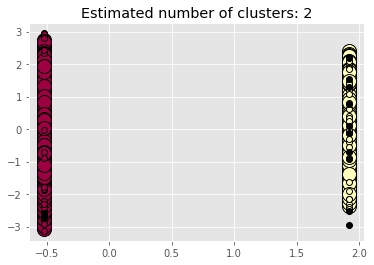

In [20]:
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler


# #############################################################################
#https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html

X = StandardScaler().fit_transform(x_fs)

# #############################################################################
# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)


# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

Clearly, with two clusters and 15 noise points, all datapoints fall into the two groups on the scale.

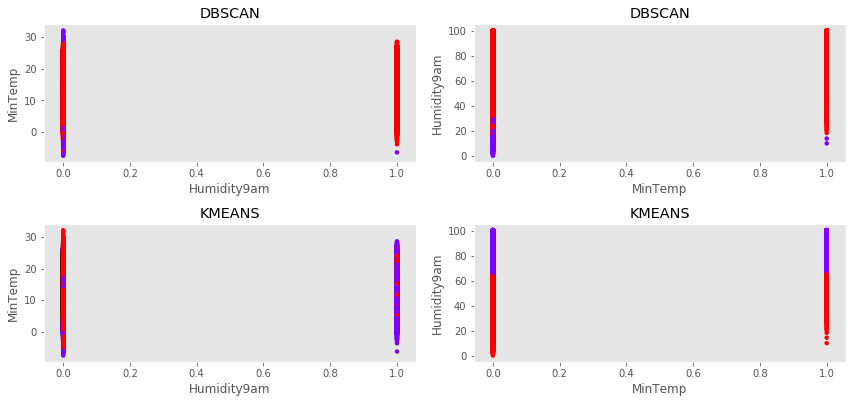

In [21]:
from sklearn.cluster import AgglomerativeClustering

data = x_fs

cls = DBSCAN(eps=3.5, min_samples=500)
cls.fit(data)
dbs_labels = cls.labels_ 


cls = KMeans(n_clusters=2, random_state=1)
cls.fit(data)
kmn_labels = cls.labels_

fig = plt.figure(figsize=(12,8))
title = ['DBSCAN','KMEANS']

for i,l in enumerate([dbs_labels,kmn_labels]):
    
    plt.subplot(3,2,2*i+1)
    plt.scatter(data[:, 0], data[:, 1]+numpy.random.random(data[:, 1].shape)/2, c=l, cmap=plt.cm.rainbow, s=20, linewidths=0)
    plt.xlabel('Humidity9am'), plt.ylabel('MinTemp')
    plt.grid()
    plt.title(title[i])
    
    plt.subplot(3,2,2*i+2)
    plt.scatter(data[:, 0], data[:, 2]+numpy.random.random(data[:, 1].shape)/2, c=l, cmap=plt.cm.rainbow, s=20, linewidths=0)
    plt.xlabel('MinTemp'), plt.ylabel('Humidity9am')
    plt.grid()
    plt.title(title[i])
    
    


plt.tight_layout()
plt.show()

# Modeling and Evaluation 4
<b>Summarize the Ramifications</b>


In [27]:
DBSCAN()

DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=5, n_jobs=1, p=None)

Based on our results, more analysis is required with different variables of the dataset. The results we found were that there were never more than 2 clusters in all the different ways that we attempted to cluster the data. Additionally, several of the types of classification methods in Sklearn were not successful due to the nature and size of our dataset.  

Hindsight may have led us to a different dataset, however, after investing so much time on this data for the Mini-lab and Lab 2, we decided to stick to this set and report our findings as is.

The most interesting findings were that the clustering was not as effecient as we thought it would be. We also found it interesting that there were never more than two clusters. Due to the fact that two of our variables in our final dataset were binary, this could have been the cause.  However, we would still think that there would be more than two clusters in at least one combination of parameters.

# Deployment
<b>Be critical of your performance and tell the reader how you current model might be usable by other parties. Did you achieve your goals? If not, can you reign in the utility of your modeling?</b>

* How useful is your model for interested parties (i.e., the companies or organizations that might want to use it)?
<br>
Our model would be very useful for any businesses or organizations or individuals that are planning day-to-day activities that can be affected by rain.  Farmers need information to help plan for planting and harvesting crops.  Airports require rain information to prepare for flight delays and/or cancellations.  Weather forecasting in general helps individuals make informed daily decisions (and in some cases, save lives).  As new weather patterns emerge, global citizens, businesses, and governments need accurate weather prediction to anticipate the unknowns to avoid/mitigate losses.  In states like California where the year's past have experienced extended drought seasons, being able to find feature sets and clusters to guide water preservation strategies is essential to the livelihood of its citizens.  Suffice to say, our model could save thousands of lives.  
<br>
* How would your deploy your model for interested parties?
<br>
The model could be deployed in various platforms but we could see this as an API that inserts into the organization's business application database.  In general, weather forecasting requires a combination of computer modeling, observation, and a domain expert with knowledge of trends and patterns.  Ideally, there would be two way communication between sender and receiver.  The receiver could return back a binary response on whether the prediction was correct.  This could then add more dimensionality to the model with the hopes of making it more accurate.
<br>
* What other data should be collected?
As mentioned above, a binary response from the receiver of the results on whether it was correct.  With emerging technology such as 5g, IoT, and edge computing, more real-time and precious data could be gathered, processed, and added to the current model.  The raw data set had many NAs reducing the dimensionality by 40,0000 observations - a reduction around 30%.  In cases where there are missing values, a feature providing reasons why could be collected and add to the models accuracy.  It could also have a significant impact on exploratory data mining techniques such as clustering and association.
* How often would the model need to be updated, etc.?
<br>
Initially, the model would need to be updated weekly and up until we can get to a goal of 80% accuracy.  This could take months to years as climate is constantly changing, which effects the prediction of rain.  Our guess would be the model will require periodic changes and never stops changing as the prediction accuracy could flutuate.  Furthermore, with global warming as an unknown variable, past measurements could be nullify as new weather patterns could emerge from it.  

# Exceptional Work
<b>You have free reign to provide additional analyses or combine analyses</b>

In the interest of trying 'just one more thing' to see if we can get a better output, we will use the exceptional work section to test 2 or 3 other combinations of variables with our final dataset. 

These sets of variables are not being chosen due to regression, dementionality reduction, or any other statistical measure, so we cannot use this to report on for our paper.

In [24]:
#http://localhost:8888/notebooks/Documents/GitHub/DataMiningNotebooks/09.%20Clustering%20and%20Discretization.ipynb
#checking the original file for completeness and renaming the file in order to 'experiment' with it.

temp_rainfall.info()

exceptional_rainfall = temp_rainfall.drop(['MinTemp', 'MaxTemp', 'Pressure9am', 'Temp9am'], axis = 1)

exceptional_rainfall.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101328 entries, 0 to 140786
Data columns (total 18 columns):
MinTemp          101328 non-null float64
MaxTemp          101328 non-null float64
Rainfall         101328 non-null float64
WindGustDir      101328 non-null float64
WindGustSpeed    101328 non-null float64
WindDir9am       101328 non-null float64
WindDir3pm       101328 non-null float64
WindSpeed9am     101328 non-null float64
WindSpeed3pm     101328 non-null float64
Humidity9am      101328 non-null float64
Humidity3pm      101328 non-null float64
Pressure9am      101328 non-null float64
Pressure3pm      101328 non-null float64
Cloud9am         101328 non-null float64
Cloud3pm         101328 non-null float64
Temp9am          101328 non-null float64
Temp3pm          101328 non-null float64
RainToday        101328 non-null int64
dtypes: float64(17), int64(1)
memory usage: 14.7 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 101328 entries, 0 to 140786
Data columns (total 14 